# Species Distribution Modeling with Boosting<br><sub>Author: Greg Holste<br></sub>

## Introduction

Here we will apply boosted regression trees to the domain of **species distribution modeling** (SDM), or ecological niche modeling (ENM). SDM is used to model the suitable area of a species given spatial occurrence records (collected by scientists) and bioclimatic measurements at those locations. Specifically, SDM employs a classifier to distinguish a species presence from an "absence" based on the climatic features of the location of that presence/absence. So each ${\bf x_i} \in \mathbb{R}^p$ is a vector of $p$ climatic measurements, and each $y_i \in \{1, -1\} = \{presence, absence\}$ is an indicator of species presence at some unique location (latitude-longitude pair) $i$.

Sometimes researchers will "collect" species absences, but more often we must generate *pseudoabsences*. There exist many approaches to generating these psuedoabsences, each requiring us to make some assumptions about the species' distribution. One approach (used by [VanDerWal et al. 2009](https://www.journals.uchicago.edu/doi/full/10.1086/600087)) would be to randomly sample points within a radius of the observed presences. The simplest approach -- the one that makes the fewest assumptions -- is to generate random "background" points within some larger area of interest (say, an entire continent).

In this notebook, we will use CART, AdaBoost.M1, and gradient boosted regression trees (GBRT) to model the distribution of *Solanum commersonii*, a wild relative of the potato, found in parts of South America. Since R has a lot of nice tools for SDM, we will use R to fetch, clean, and visualize the bioclimatic and geospatial data, then use Python to actually fit our models and make predictions.

## Getting & Cleaning the Data

First, let's load packages and silence messages.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
shh <- suppressMessages
shh(library(raster)); shh(library(rgdal)); shh(library(dismo));
shh(library(maps)); shh(library(maptools)); shh(library(mapdata))

Fetch bioclimatic data from [WorldClim](http://worldclim.org/bioclim) at a resolution of 10 arcminutes. Here are the 19 bioclimatic features included:
* BIO1 = Annual Mean Temperature
* BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
* BIO3 = Isothermality (BIO2/BIO7) (* 100)
* BIO4 = Temperature Seasonality (standard deviation *100)
* BIO5 = Max Temperature of Warmest Month
* BIO6 = Min Temperature of Coldest Month
* BIO7 = Temperature Annual Range (BIO5-BIO6)
* BIO8 = Mean Temperature of Wettest Quarter
* BIO9 = Mean Temperature of Driest Quarter
* BIO10 = Mean Temperature of Warmest Quarter
* BIO11 = Mean Temperature of Coldest Quarter
* BIO12 = Annual Precipitation
* BIO13 = Precipitation of Wettest Month
* BIO14 = Precipitation of Driest Month
* BIO15 = Precipitation Seasonality (Coefficient of Variation)
* BIO16 = Precipitation of Wettest Quarter
* BIO17 = Precipitation of Driest Quarter
* BIO18 = Precipitation of Warmest Quarter
* BIO19 = Precipitation of Coldest Quarter

In [3]:
%%R
env <- shh(getData("worldclim", var = "bio", res = 10))

Get occurrence records for *Solanum commersonii* from [GBIF](https://www.gbif.org/). This provides a lot of information (>100 columns) about each record, but we are really only concerned with the latitude and longitude.

In [4]:
%%R
species <- shh(gbif("Solanum", "commersonii"))
print(paste(nrow(species), "rows |", ncol(species), "columns"))
print(head(species[, c("acceptedScientificName", "lon", "lat", "year")]))

[1] "2247 rows | 124 columns"
     acceptedScientificName       lon       lat year
1 Solanum commersonii Poir. -49.44861 -26.28639 2018
2 Solanum commersonii Poir.        NA        NA 2018
3 Solanum commersonii Poir. -49.41083 -26.91000 2017
4 Solanum commersonii Poir.        NA        NA 2017
5 Solanum commersonii Poir.        NA        NA 2017
6 Solanum commersonii Poir.        NA        NA 2017


Remove occurrences without latitude and longitude, then remove duplicate occurrences.

In [5]:
%%R
species <- subset(species, !is.na(lat) & !is.na(lon))

dup_rm <- duplicated(species[, c("lat", "lon")])
species <- species[!dup_rm, ]

print(paste(nrow(species), "rows |", ncol(species), "columns"))
print(head(species[, c("acceptedScientificName", "lon", "lat", "year")]))

[1] "529 rows | 124 columns"
                   acceptedScientificName       lon       lat year
1               Solanum commersonii Poir. -49.44861 -26.28639 2018
3               Solanum commersonii Poir. -49.41083 -26.91000 2017
7  Solanum commersonii subsp. commersonii -95.00000 -33.00000 2017
9               Solanum commersonii Poir. -53.00000 -33.00000 2017
11              Solanum commersonii Poir. -47.10222 -23.51556 2016
12              Solanum commersonii Poir. -47.06080 -22.90560 2016


Below, we can see most occurrences are concentrated in southern Brazil, Paraguay, Uruguay, and eastern Argentina. As is often the case when examining species occurrence records, it is hard to know whether this represents the true distribution of *S. commersonii* or simply reflects where researchers most frequently took their samples. There are a hanful of occurrences outside this concentrated region though, which suggests the suitable range of this plant could actually be broader than this tight clump of occurrence records suggests.

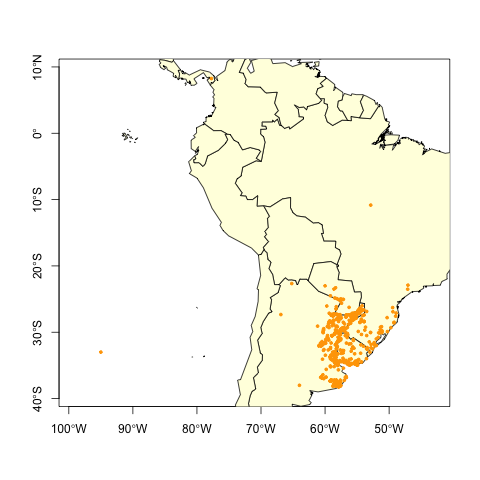

In [6]:
%%R
data(wrld_simpl)
plot(wrld_simpl,
     xlim = c(min(species$lon) - 1, max(species$lon) + 1),
     ylim = c(min(species$lat) - 1, max(species$lat) + 1),
     col = "light yellow",
     axes = T)
points(species$lon, species$lat, col = "orange", pch = 20, cex = 0.75)

We see one occurrence seems to be in the ocean, so... let's get rid of that.

In [7]:
%%R
species <- subset(species, lon > -90)
print(paste("Now", nrow(species), "occurrences"))

[1] "Now 528 occurrences"


Now we can crop our scope of interest to a reasonable area (10 degrees beyond the observed max/min latitude/longitude instead of the entire world). Then we'll extract the 19 bioclimatic features for the locations where we have *S. commersonii* occurrences.

In [8]:
%%R
model_env <- crop(env,
                  extent(min(species$lon) - 10, max(species$lon) + 10,
                         min(species$lat) - 10, max(species$lat) + 10)
                  )

# Extract bioclimatic features for our presences
presence_features <- extract(model_env, species[, c("lon", "lat")])

# Check for NAs and remove from both occurrence and climatic data
idx_rm <- which(is.na(presence_features[, 3]))
presence_features <- presence_features[-idx_rm, ]
species <- species[-idx_rm, ]

Generate "background" occurrences from this reduced extent (area of interest), extract bioclimatic features from those pseudoabsences, then combine all this information into a single data frame for modeling.

In [9]:
%%R
# Create random background points/occurrences
set.seed(1)
bg <- randomPoints(model_env, nrow(species))
absence_features <- extract(model_env, bg)

# Combine into one data frame
sdm_data <- data.frame(
  Presence = c(rep(1, nrow(presence_features)), rep(-1, nrow(absence_features)))
)
sdm_data$lon <- c(species$lon, bg[, 1])
sdm_data$lat <- c(species$lat, bg[, 2])
sdm_data <- cbind(sdm_data, rbind(presence_features, absence_features))
write.csv(sdm_data, "Data/S_commersonii_SDM_data.csv", row.names = F)

print(paste(nrow(sdm_data), "rows |", ncol(sdm_data), "columns"))
print(head(sdm_data))

[1] "1054 rows | 22 columns"
  Presence       lon       lat bio1 bio2 bio3 bio4 bio5 bio6 bio7 bio8 bio9
1        1 -49.44861 -26.28639  166  107   55 2977  261   67  194  203  129
2        1 -49.41083 -26.91000  185  100   53 2952  282   95  187  220  148
3        1 -53.00000 -33.00000  173   93   47 3522  281   85  196  130  192
4        1 -47.10222 -23.51556  172  102   60 2296  250   80  170  199  141
5        1 -47.06080 -22.90560  194  115   63 2363  273   91  182  219  161
6        1 -52.00000 -31.00000  187   92   46 3474  291   94  197  151  221
  bio10 bio11 bio12 bio13 bio14 bio15 bio16 bio17 bio18 bio19
1   203   128  1448   175    81    24   480   279   476   289
2   221   148  1572   179    90    21   505   296   501   317
3   216   129  1197   113    86     9   326   273   301   318
4   200   141  1517   249    46    56   686   149   645   149
5   219   161  1311   222    26    63   627   102   627   102
6   230   142  1391   136    86    14   396   292   359   395


Visualize all presences and pseudoabsences of *S. commersonii*.

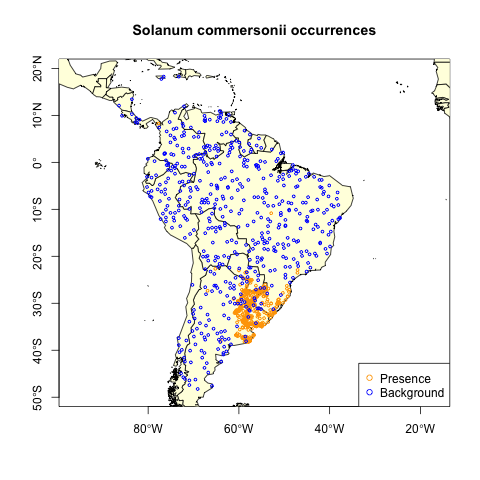

In [10]:
%%R
plot(wrld_simpl,
     xlim = c(min(sdm_data$lon) + 10, max(sdm_data$lon) + 1),
     ylim = c(min(sdm_data$lat) - 1, max(sdm_data$lat) + 1),
     col = "light yellow",
     axes = T)
points(species$lon, species$lat, col = "orange", pch = 21, cex = 0.5)
points(bg[, 1], bg[, 2], col = "blue", pch = 21, cex = 0.5)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 21,
       col = c("orange", "blue"),
       cex = 1)
title("Solanum commersonii occurrences")

Now let's switch to Python and prepare the data to fit a classifier.

In [11]:
from CART import *
from boosting import *
np.random.seed(0)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

sdm_data = pd.read_csv("Data/S_commersonii_SDM_data.csv")
print(sdm_data.shape)
sdm_data.head()

(1054, 22)


,Presence,lon,lat,bio1,bio2,bio3,bio4,bio5,bio6,bio7,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,1,-49.448611,-26.286389,166,107,55,2977,261,67,194,...,203,128,1448,175,81,24,480,279,476,289
1,1,-49.410833,-26.910000,185,100,53,2952,282,95,187,...,221,148,1572,179,90,21,505,296,501,317
2,1,-53.000000,-33.000000,173,93,47,3522,281,85,196,...,216,129,1197,113,86,9,326,273,301,318
3,1,-47.102222,-23.515556,172,102,60,2296,250,80,170,...,200,141,1517,249,46,56,686,149,645,149
4,1,-47.060800,-22.905600,194,115,63,2363,273,91,182,...,219,161,1311,222,26,63,627,102,627,102


Split observations into training and testing sets with an approximate 80:20 split.

In [12]:
X = sdm_data.drop(["Presence", "lon", "lat"], axis=1).to_numpy()
y = sdm_data["Presence"].ravel()

N = X.shape[0]
np.random.seed(0)
test_idxs = np.random.choice(range(N), size=int(0.2 * N), replace=False)
train_idxs = np.array(list(set(range(N)).difference(set(test_idxs))))

X_test, y_test = X[test_idxs, :], y[test_idxs]
X_train, y_train = X[train_idxs, :], y[train_idxs]

print(X_train.shape[0], "training observations (each with", X_train.shape[1], "features)")
print(X_test.shape[0], "test observations")

844 training observations (each with 19 features)
210 test observations


## CART: Results

Finally, we can train a decision tree to classify presences from pseudoabsences based on our $19$ climatic predictors. For simplicity, we will choose a decision tree with minimum terminal node size $d=1$.

In [13]:
DT = DecisionTreeClassifier(random_state=0, min_samples_leaf=1)
_ = DT.fit(X_train, y_train)

Now we can evaluate how this model performs on the test set. 

In [14]:
print(f"Training accuracy: {round(DT.score(X_train, y_train) * 100, 2)}%")
print(f"Test accuracy: {round(DT.score(X_test, y_test) * 100, 2)}%")

Training accuracy: 99.53%
Test accuracy: 92.38%


While decision trees are often lauded for their tractibility, it's sometimes unreasonable to visualize the entire fitted tree. Instead, we can find our tree's "depth" (the number of levels from root to lowest leaf) and the total number of terminal nodes.

In [16]:
print("Tree depth:", DT.get_depth())
print("No. leaves:", DT.get_n_leaves())

Tree depth: 15
No. leaves: 56


To get a better sense of how our model works internally, we can also find *feature importance* values. These are exactly what they sound like – they measure the "importance" of a predictor usually by considering how frequently they are used as a splitting variable as well as how fruitful those splits are.

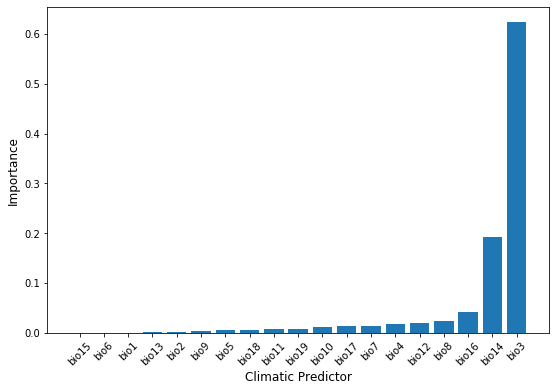

In [17]:
DT_imp_df = pd.DataFrame({"Predictors": sdm_data.columns.values[3:],
                          "Importance": DT.feature_importances_})
DT_imp_df = DT_imp_df.sort_values(["Importance"])

fig, ax = plt.subplots(figsize=(9,6))
plt.xticks(rotation=45)
ax.bar(DT_imp_df["Predictors"], DT_imp_df["Importance"])
ax.set_xlabel("Climatic Predictor", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
plt.show()

We see $BIO3$, or *isothermality* is far and away the most imporant predictor according to this particular measure. Isothermality a ratio of diurnal temperature range ($BIO2$) to annual temperature range ($BIO7$); in other words, it quantifies "how \[much\] the day-to-night temperatures oscillate relative to the summer-to-winter (annual) oscillations" ([source](https://pubs.usgs.gov/ds/691/ds691.pdf)). The next two most important predictors ($BIO16$ and $BIO14$) are both related to precipitation levels.

We can see why isothermality is so important with the histograms below (mean $BIO3$ value marked with a red dashed line). The mean of and variation in $BIO3$ for species presences are *both* smaller than those of pseudoabsences. That is, the areas where *S. commersonii* are found seem to have a characteristically small isothermality; these regions have smaller variability in monthly temperature than in yearly temperature, and the same is decidedly *not* true for our pseudoabsences.

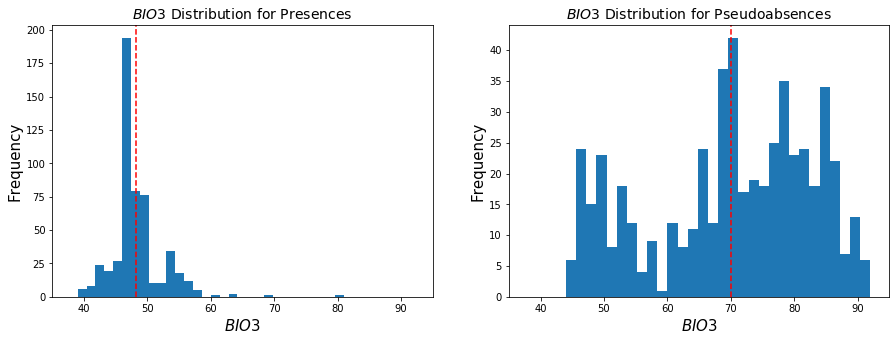

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(sdm_data.loc[sdm_data["Presence"] == 1, "bio3"], bins=30)
ax[0].set_xlim(35, 95)
ax[0].axvline(x=np.mean(sdm_data.loc[sdm_data["Presence"] == 1, "bio3"]), linestyle="--", color="r")
ax[0].set_xlabel("$BIO3$", fontsize=15)
ax[0].set_ylabel("Frequency", fontsize=15)
ax[0].set_title("$BIO3$ Distribution for Presences", fontsize=14)
ax[1].hist(sdm_data.loc[sdm_data["Presence"] == -1, "bio3"], bins=30)
ax[1].set_xlim(35, 95)
ax[1].axvline(x=np.mean(sdm_data.loc[sdm_data["Presence"] == -1, "bio3"]), linestyle="--", color="r")
ax[1].set_xlabel("$BIO3$", fontsize=15)
ax[1].set_ylabel("Frequency", fontsize=15)
ax[1].set_title("$BIO3$ Distribution for Pseudoabsences", fontsize=14)
plt.show()

Lastly, we can plot a **confusion matrix** of our results on the test set. Letting $C$ be the number of output classes, this tabulates all test set observations in a $C x C = 2 x 2$ matrix according to their true and predicted outcomes. This allows us to visualize the *types* of errors our model makes.

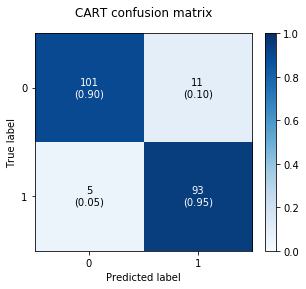

In [19]:
cm = confusion_matrix(y_test, DT.predict(X_test))
fig, ax = plot_confusion_matrix(cm, show_normed=True, colorbar=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("CART confusion matrix")
fig.savefig("Figs/CM_DT.png", dpi=600, bbox_inches="tight")
plt.show()

This means ~$5\%$ of presences were misclassified as pseudoabsences (called a *false negative*) and ~$10\%$ of pseudoabsences were wrongly classified as presences (*false positive*).

## CART: Visualize Predictions

Export bioclimatic data for *all* cells with such data. This is so that we can read these features into Python and make predictions for every cell in our environmental extent of interest.

In [20]:
%%R
model_env_data <- data.frame(values(model_env))
model_env_data <- model_env_data[complete.cases(model_env_data), ]
print(head(model_env_data))
write.csv(model_env_data, "Data/model_env_data.csv", row.names = F)

   bio1 bio2 bio3 bio4 bio5 bio6 bio7 bio8 bio9 bio10 bio11 bio12 bio13 bio14
56  261   78   72  918  313  205  108  270  248   270   247  1577   222    48
57  260   75   72  893  311  207  104  269  248   269   247  1822   257    56
58  252   71   71  901  301  201  100  261  240   262   239  2056   280    61
59  233   71   70  899  283  182  101  242  221   243   220  2415   336    67
60  232   71   70  917  282  181  101  240  219   242   219  2207   308    73
61  220   73   70  931  272  168  104  229  208   231   208  1996   296    75
   bio15 bio16 bio17 bio18 bio19
56    48   590   157   543   168
57    49   678   178   622   194
58    49   774   199   717   211
59    50   931   221   847   243
60    46   832   231   715   244
61    43   742   237   586   237


Read environmental data into Python and print to confirm it is indeed the same data. Now we will make predictions using our trained decision tree for every cell with climatic information.

In [22]:
model_env_data = pd.read_csv("Data/model_env_data.csv")
print(model_env_data.shape[0], "cells to make predictions for")
print(model_env_data.head())

DT_probs = DT.predict_proba(model_env_data)[:, 1]

56309 cells to make predictions for
   bio1  bio2  bio3  bio4  bio5  bio6  bio7  bio8  bio9  bio10  bio11  bio12  \
0   261    78    72   918   313   205   108   270   248    270    247   1577   
1   260    75    72   893   311   207   104   269   248    269    247   1822   
2   252    71    71   901   301   201   100   261   240    262    239   2056   
3   233    71    70   899   283   182   101   242   221    243    220   2415   
4   232    71    70   917   282   181   101   240   219    242    219   2207   

   bio13  bio14  bio15  bio16  bio17  bio18  bio19  
0    222     48     48    590    157    543    168  
1    257     56     49    678    178    622    194  
2    280     61     49    774    199    717    211  
3    336     67     50    931    221    847    243  
4    308     73     46    832    231    715    244  


Now we'll load those predictions back into R and add them as a layer to our raster brick for easy visualization.

In [23]:
%%R -i DT_probs
idx <- as.numeric(rownames(model_env_data))
DT_prob <- rep(NA, nrow(values(model_env)))
DT_prob[idx] <- DT_probs

values(model_env) <- cbind(values(model_env), DT_prob)

Finally, here is the predicted suitability for *S. commersonii* produced by our decision tree.

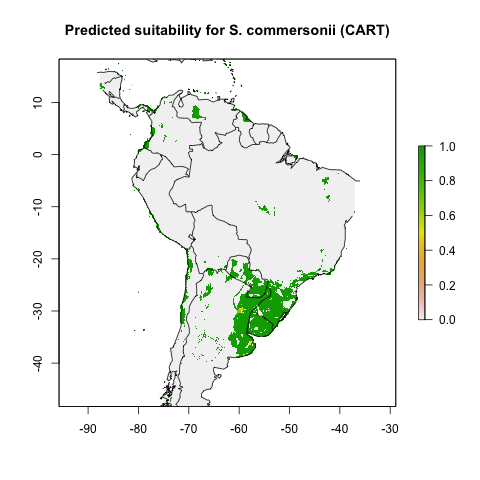

In [24]:
%%R
plot(model_env$DT_prob)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
title("Predicted suitability for S. commersonii (CART)")

By "thresholding" those predicted probabilities at $0.5$ (so that $1 = presence$ and $0 = absence$) we can visualize the actual decisions our model would make throughout this area. We can also plot our test set observations (labeled "presence" or "absence") to visualize where they are found and whether or not these observations fell in the proper region.

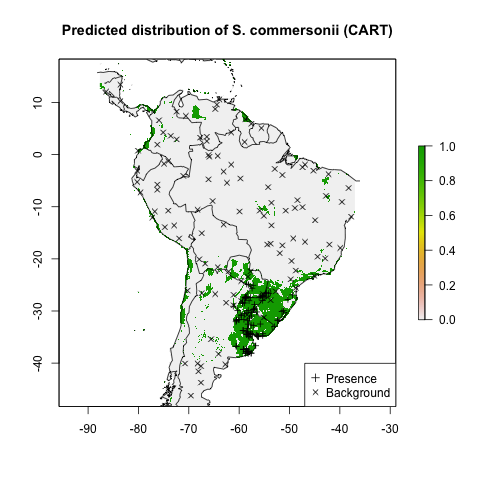

In [25]:
%%R -i test_idxs
test_idxs <- test_idxs + 1

plot(model_env$DT_prob > 0.5)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
points(with(sdm_data[test_idxs, ], lon[Presence == 1]),
       with(sdm_data[test_idxs, ], lat[Presence == 1]),
       pch = 3, cex = 0.75)
points(with(sdm_data[test_idxs, ], lon[Presence == -1]),
       with(sdm_data[test_idxs, ], lat[Presence == -1]),
       pch = 4, cex = 1)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 3:4,
       cex = 1)
title("Predicted distribution of S. commersonii (CART)")

## AdaBoost: Model Selection
To hopefully improve upon the performance of a single decision tree, we can now apply AdaBoost.M1 to this same problem. Here we will use a **grid search with $5$-fold cross-validation** to select the number of trees $M$ and the depth of each tree $J$. This involves specifying a "grid" of parameters to exhaust; that is, we will fit an AdaBoost classifier with each unique combination of parameters on this grid $K=5$ times, once for each fold.

For the following parameter grid, we will fit $7 \cdot 3 = 21$ different models. Since we perform $5$-fold cross-validation on each model, this means we train $21 \cdot 5 = 105$ AdaBoost classifiers in total. We then proceed with the model with highest mean validation accuracy across all $5$ folds.

In [26]:
param_grid = {
    "n_estimators": [50, 100, 500, 1000, 2000, 3000, 5000],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=0),
                       DecisionTreeClassifier(max_depth=2, random_state=0),
                       DecisionTreeClassifier(max_depth=3, random_state=0)]  # try J=1,2,3
}

AB = AdaBoostClassifier(random_state=0, algorithm="SAMME")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
AB_GS = GridSearchCV(estimator=AB, param_grid=param_grid, cv=kfold, verbose=0)
_ = AB_GS.fit(X_train, y_train)

In [27]:
AB_best = AB_GS.best_estimator_
print(f"Best model acheived {round(AB_GS.best_score_ * 100, 2)}% mean validation accuracy with...")
print("  M =", AB_best.get_params()["n_estimators"])
print("  J =", AB_best.get_params()["base_estimator"].get_params()["max_depth"])

Best model acheived 94.55% mean validation accuracy with...
  M = 500
  J = 3


## AdaBoost: Results
Now we re-fit this model to the entire training set and can evaluate its performance on the test set. As we expected, boosting thankfully outperforms a single tree on the test set.

In [28]:
AB_best.fit(X_train, y_train)

print(f"Training accuracy: {round(AB_best.score(X_train, y_train) * 100, 2)}%")
print(f"Test accuracy: {round(AB_best.score(X_test, y_test) * 100, 2)}%")

Training accuracy: 99.53%
Test accuracy: 94.29%


To again show that our AdaBoost implementation in `boosting.py` is equivalent, we can reproduce the above results: 

In [30]:
AB2 = AdaBoost(X_train, y_train, M=500, J=3)
AB2.fit()

print(f"Training accuracy: {round(acc(y_train, AB2.predict(X_train)) * 100, 2)}%")
print(f"Test accuracy: {round(acc(y_test, AB2.predict(X_test)) * 100, 2)}%")

Training accuracy: 99.53%
Test accuracy: 94.29%


Now let's look at another feature importance plot.

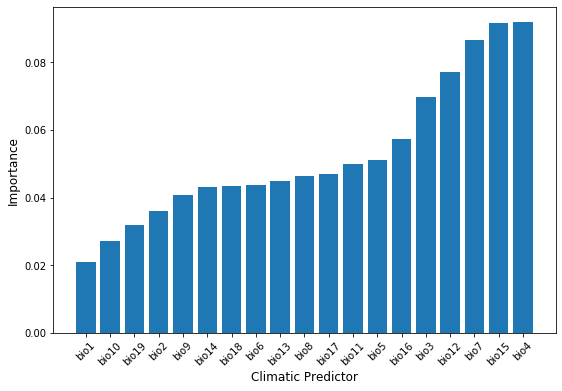

In [31]:
AB_imp_df = pd.DataFrame({"Predictors": sdm_data.columns.values[3:], "Importance": AB_best.feature_importances_})
AB_imp_df = AB_imp_df.sort_values(["Importance"])

fig, ax = plt.subplots(figsize=(9,6))
plt.xticks(rotation=45)
ax.bar(AB_imp_df["Predictors"], AB_imp_df["Importance"])
ax.set_xlabel("Climatic Predictor", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
plt.show()

We find that the distribution of feature importance values is *much* more uniform than for a single tree. It is interesting to note that $BIO4$, $BIO12$, $BIO14$, and $BIO15$ all involve precipitation, so this model seems to consider precipitation levels and variability to be more important than our single tree did. Also $BIO3$ is still one of the most important features.

Plotting a confusion matrix, we can see both types of misclassification rates were improved (decreased) relative to our single classification tree. The false negative rate (upper right entry) decreased from ~$10\%$ to ~$8\%$, and the false positive rate (lower left entry) decreased from ~$5\%$ to ~$3\%$.

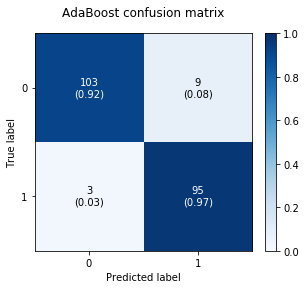

In [33]:
cm = confusion_matrix(y_test, AB2.predict(X_test))
fig, ax = plot_confusion_matrix(cm, show_normed=True, colorbar=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("AdaBoost confusion matrix")
fig.savefig("Figs/CM_AdaBoost.png", dpi=600, bbox_inches="tight")
plt.show()

## AdaBoost: Visualize Predictions

Find predicted probabilities of *S. commersonii* presence according to our tuned AdaBoost model for all cells in our extent.

In [34]:
AB_probs = AB_best.predict_proba(model_env_data)[:, 1]

Add predicted probability as another layer to our raster brick and plot the results. Interesting to see our model is not very "decisive;" that is, all predicted probabilities are quite close to $0.5$.

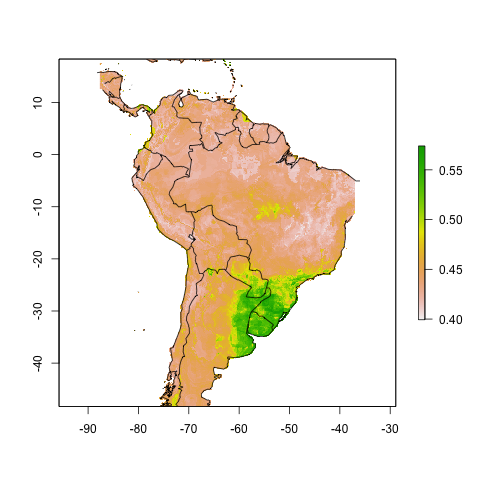

In [35]:
%%R -i AB_probs
AB_prob <- rep(NA, nrow(values(model_env)))
AB_prob[idx] <- AB_probs
values(model_env) <- cbind(values(model_env), AB_prob)

plot(model_env$AB_prob)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)

Like before, threshold predictions at $0.5$ to visualize the presence/absence decisions our AdaBoost classifier would make.

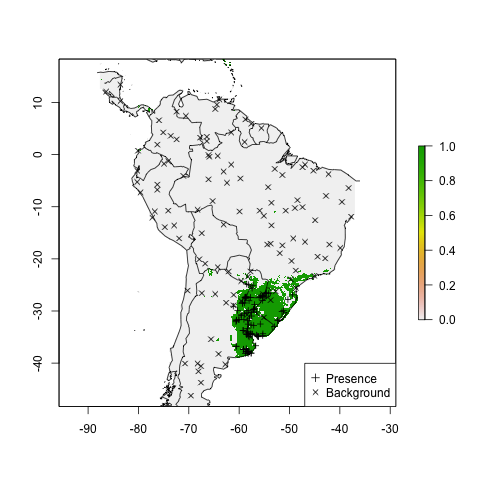

In [36]:
%%R
plot(model_env$AB_prob > 0.5)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
points(with(sdm_data[test_idxs, ], lon[Presence == 1]),
       with(sdm_data[test_idxs, ], lat[Presence == 1]),
       pch = 3, cex = 0.75)
points(with(sdm_data[test_idxs, ], lon[Presence == -1]),
       with(sdm_data[test_idxs, ], lat[Presence == -1]),
       pch = 4, cex = 1)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 3:4,
       cex = 1)

## GBRT: Model Selection
One last time, we will repeat this same model selection process, but now with gradient boosted regression trees (GBRT). We will use a larger parameter grid of $3 \cdot 7 \cdot 3 = 63$ hyperparameter combinations of learning rate $\lambda$, number of trees $M$, and depth of each tree $J$. This means we will fit $63 \cdot 5 = 315$ GBRT models in total.

In [37]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [50, 100, 500, 1000, 2000, 3000, 5000],
    "max_depth": [1, 2, 3]
}

GB = GradientBoostingClassifier(random_state=0)

GB_GS = GridSearchCV(estimator=GB, param_grid=param_grid, cv=kfold, verbose=0)
_ = GB_GS.fit(X_train, y_train)

In [38]:
GB_best = GB_GS.best_estimator_
print(f"Best model acheived {round(GB_GS.best_score_ * 100, 2)}% mean validation accuracy with...")
print("  M =", GB_best.get_params()["n_estimators"])
print("  J =", GB_best.get_params()["max_depth"])
print("  lambda =", GB_best.get_params()["learning_rate"])

Best model acheived 94.79% mean validation accuracy with...
  M = 2000
  J = 3
  lambda = 0.001


## GBRT: Results

This model (fitting $M=2000$ trees, each with depth $J=3$, with $\lambda = 0.001$) performs better than a single decision tree, but slightly worse than our AdaBoost model.

In [39]:
GB_best.fit(X_train, y_train)

print(f"Training accuracy: {round(GB_best.score(X_train, y_train) * 100, 2)}%")
print(f"Test accuracy: {round(GB_best.score(X_test, y_test) * 100, 2)}%")

Training accuracy: 96.33%
Test accuracy: 93.81%


Looking at our feature importance plot, we see this model is quite different from the AdaBoost classifier in terms of how it arrives at predictions. This plot looks a lot more like the importance plot for our single tree, heavily favoring $BIO3$ over all other features. 

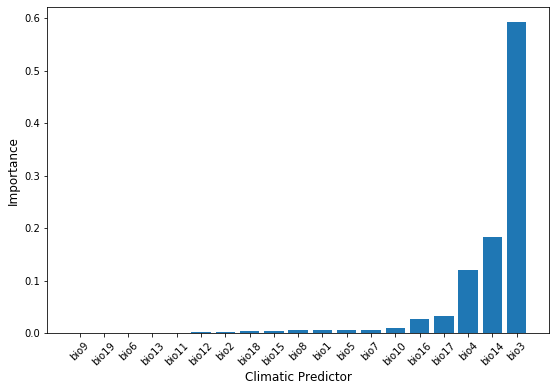

In [41]:
GB_imp_df = pd.DataFrame({"Predictors": sdm_data.columns.values[3:], "Importance": GB_best.feature_importances_})
GB_imp_df = GB_imp_df.sort_values(["Importance"])

fig, ax = plt.subplots(figsize=(9,6))
plt.xticks(rotation=45)
ax.bar(GB_imp_df["Predictors"], GB_imp_df["Importance"])
ax.set_xlabel("Climatic Predictor", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
plt.show()

The following confusion matrix reveals that we have increased our false negative rate from $~8\%$ to to $10\%$, but decreased (improved) our false positive rate from ~$3\%$ to ~$2\%$. Note that these are very slight changes in performance – a matter of two or three different predictions.

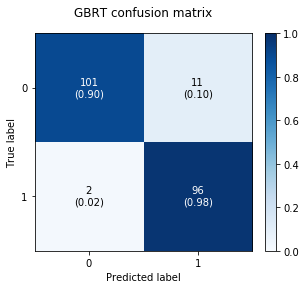

In [42]:
cm = confusion_matrix(y_test, GB_best.predict(X_test))
fig, ax = plot_confusion_matrix(cm, show_normed=True, colorbar=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("GBRT confusion matrix")
fig.savefig("Figs/CM_GBRT.png", dpi=600, bbox_inches="tight")
plt.show()

## GBRT: Visualize Predictions
Here is the predicted suitability of *S. commersonii* according to our tuned GBRT model. Note that this model is much more "decisive" than the AdaBoost classifier, though its predictions are almost identical!

In [43]:
GB_probs = GB_best.predict_proba(model_env_data)[:, 1]  # make predictions for env

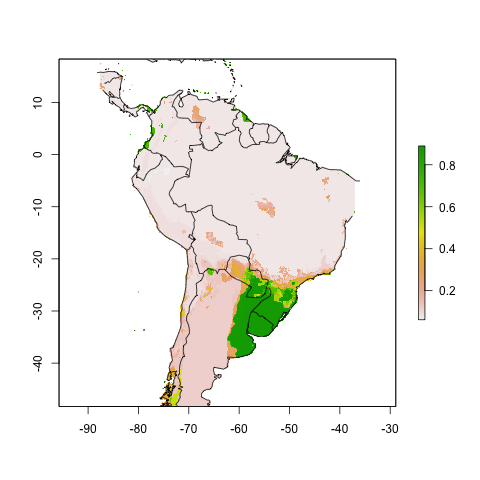

In [44]:
%%R -i GB_probs
GB_prob <- rep(NA, nrow(values(model_env)))
GB_prob[idx] <- GB_probs
values(model_env) <- cbind(values(model_env), GB_prob)

plot(model_env$GB_prob)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)

After thresholding predicted probabilities at $0.5$, we see this model's predicted distribution of *S. commersonii* is quite concentrated, much like the original observed distribution.

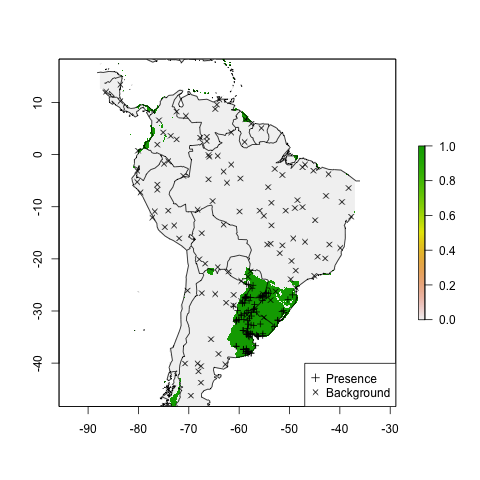

In [45]:
%%R
plot(model_env$GB_prob > 0.5)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
points(with(sdm_data[test_idxs, ], lon[Presence == 1]),
       with(sdm_data[test_idxs, ], lat[Presence == 1]),
       pch = 3, cex = 0.75)
points(with(sdm_data[test_idxs, ], lon[Presence == -1]),
       with(sdm_data[test_idxs, ], lat[Presence == -1]),
       pch = 4, cex = 1)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 3:4,
       cex = 1)

## Conclusion

As expected, boosting improves upon the generalization accuracy of a single classification tree, though not dramatically. Overall, a single tree actually had the best true negative rate (~$94\%$); the improvements made by boosting were primarily to the true positive rate (correctly classifying presences). Interestingly, despite different parameters, feature importance distributions, and strengths of predicted probabilities, GBRT and AdaBoost make very similar predictions on the test set even though AdaBoost produced a slightly higher overall test accuracy.

<table align="center">
<tr>
<td> <img src="Figs/CM_DT.png" alt="Drawing" /> </td>
<td> <img src="Figs/CM_AdaBoost.png" alt="Drawing" /> </td>
<td> <img src="Figs/CM_GBRT.png" alt="Drawing" /> </td>
</tr>
</table>

To visualize the similarity between the predictions from AdaBoost and GBRT, we can simply plot the absolute value of the difference between the predictions from these two models. This reveals where exactly the two models differ in where they would predict *S. commersonii* could reasonably be found.

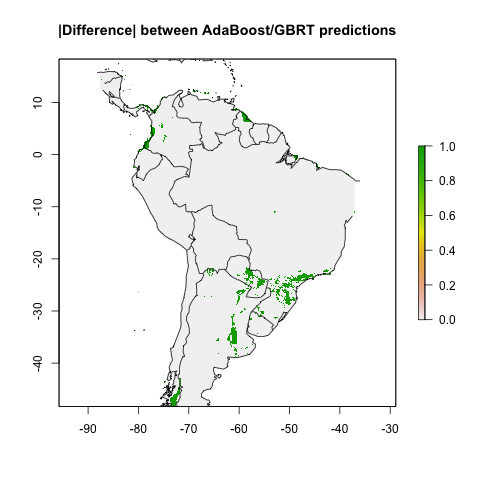

In [46]:
%%R
plot(abs((model_env$AB_prob > 0.5) - (model_env$GB_prob > 0.5)))
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
title("|Difference| between AdaBoost/GBRT predictions")

We can also construct a similar plot for the absolute difference between predicted probabilities for each model. We see the largest disagreement actually occurs in regions where the models agree *S. commersonii* is *not* found; the large difference is simply because the GBRT output is much closer to $0$ in those regions (it is "more certain" the species does not occur there).

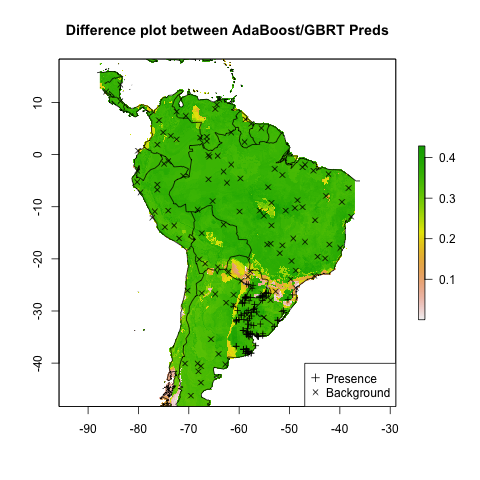

In [47]:
%%R
plot(abs(model_env$AB_prob - model_env$GB_prob))
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
points(with(sdm_data[test_idxs, ], lon[Presence == 1]),
       with(sdm_data[test_idxs, ], lat[Presence == 1]),
       pch = 3, cex = 0.75)
points(with(sdm_data[test_idxs, ], lon[Presence == -1]),
       with(sdm_data[test_idxs, ], lat[Presence == -1]),
       pch = 4, cex = 1)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 3:4,
       cex = 1)
title("Difference plot between AdaBoost/GBRT Preds")

As a final note, it is potentially dubious to interpret the suitability plots as *probabilities* of presence. When making a prediction for some observation ${\bf x}$, the most frequent output class among training labels in that node is not necessarily an accurate representation of the predicted probability that ${\bf x}$ belongs to that class. However, it can be useful to examine these probability-like outputs to understand how finely our model is splitting output classes.

Lastly, we could consider using thresholds other than $0.5$. Perhaps a lower threshold of $0.3$ actually increases overall accuracy. This analysis of finding the optimal threshold can be achieved through ROC-AUC (receiver operating characteristic-area under curve) analysis, but has been left out of this analysis.

All that being said, we successfully used boosting to make reasonable predictions about the distribution of the crop wild relative *Solanum commersonii*!